In [163]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from overlap import *  # bad practice
from IPython.display import display

from astropy.io import fits
from astropy.table import Table
from astropy import stats
import sklearn
from scipy.stats import gaussian_kde, ks_2samp
from scipy.interpolate import interp1d
from scipy import integrate 

import seaborn as sns
sns.set_context('poster')

from axial_ratio_comparison import cache_nsa, get_agn_catalog
from shared_utilities import plot_catalog, plot_catalog_overlap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data - NSA, DR7 Catalog, Heckman AGN catalog, Galaxy Zoo 2

Descriptions and download links for the DR7 catalog:
* http://home.strw.leidenuniv.nl/~jarle/SDSS/
* https://wwwmpa.mpa-garching.mpg.de/SDSS/

In [2]:
heckman = get_heckman_catalog(heckman_loc='/data/repos/find_agn/catalogs/sdss_dr7_radiosources.cat')
galaxy_zoo = pd.read_csv('/data/galaxy_zoo/gz2/subjects/gz2_hart16.csv')

/Data/repos/find_agn/overlap.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table(heckman_loc, sep=r"\s*")
/data/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/data/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [3]:
def cache_galloway(table_loc, csv_loc):
    galloway = Table.read(table_loc)
    for col in galloway.colnames:
        galloway.rename_column(col, col.lower())
    galloway.rename_column('u-r color', 'u-r_color')
    galloway.rename_column('velocity dispersion', 'velocity_dispersion')
    galloway.rename_column('velocity dispersion err', 'velocity_dispersion_err')
    galloway.rename_column('sdss dr7 objid', 'dr7_objid')
    galloway.rename_column('stellar mass', 'stellar_mass')
    # Table converter silently murders large ints when converting to pandas - rounding error ruins ids
    # this would be a good pull request to help out with?
    galloway['dr7_objid'] = list(map(lambda x: str(x), galloway['dr7_objid']))
    describe_bpt_class = {
        1: 'star-forming',
        0: 'undetermined',
        2: 'composite',
        4: 'liner',
        3: 'agn'}
    galloway['bpt_class'] = list(map(lambda x: describe_bpt_class[x], galloway['bpt_class']))
    galloway.to_pandas().to_csv(csv_loc, index=False)

In [4]:
table_loc = '/data/repos/find_agn/catalogs/galloway_et_al_2015_data.fits'
csv_loc = '/data/repos/find_agn/catalogs/galloway_et_al_2015_data.csv'
new_galloway = False
if new_galloway:
    cache_galloway(table_loc, csv_loc)
galloway = pd.read_csv(csv_loc, dtype={'dr7_objid': str, 'n_bar': int})

In [5]:
new_dr7 = False
source_loc = '/data/galaxy_zoo/decals/catalogs/gal_info_dr7_v5_2.fit'
cache_loc = '/data/galaxy_zoo/decals/catalogs/gal_info_dr7_v5_2_cache.csv'

In [6]:
def cache_dr7(source_loc, cache_loc):
    dr7 = Table(fits.getdata(source_loc))
    for col in dr7.colnames:
        dr7.rename_column(col, col.lower())
    bands = ['g', 'r', 'i']
    mag_cols = ['kcor_mag_{}'.format(band) for band in bands]
    for n in range(len(bands)):
        mag_col = mag_cols[n]
        dr7[mag_col] = [dr7[row]['kcor_mag'][n] for row in range(len(dr7))]
    useful_columns = ['ra','dec', 'z', 'release'] + mag_cols
    dr7[useful_columns].write(target_loc)

In [7]:
if new_dr7:
    cache_dr7(source_loc, cache_loc)
dr7 = pd.read_csv(cache_loc)

In [8]:
new_nsa = False
nsa_loc = '/data/galaxy_zoo/decals/catalogs/nsa_v1_0_1.fits'
nsa_cache_loc = '/data/galaxy_zoo/decals/catalogs/nsa_v1_0_1_cached.csv'
if new_nsa:
    useful_nsa_columns = [
    'ra',
    'dec',
    'mag',
    'petro_ba50',
    'petro_phi50',
    'petro_ba90',
    'petro_phi90',
    'elpetro_mass',
    'elpetro_phi',
#     'elpetro_flux_r',
    'elpetro_theta',
    ]
    useful_nsa_columns = list(map(lambda x: x.upper(), useful_nsa_columns))
    nsa = cache_nsa(nsa_loc, nsa_cache_loc, useful_nsa_columns)

In [9]:
nsa = pd.read_csv(nsa_cache_loc)

In [10]:
def enforce_physical_ra_limits(catalog):
    physical_catalog = catalog[(catalog['dec'] < 90.) & (catalog['dec'] > -90.)]
    print('Catalog reduced to {} from {} galaxies'.format(len(physical_catalog), len(catalog)))
    return physical_catalog

In [11]:
nsa = enforce_physical_ra_limits(nsa)
dr7 = enforce_physical_ra_limits(dr7)

Catalog reduced to 641409 from 641409 galaxies
Catalog reduced to 927551 from 927552 galaxies


## Match all catalogs to build useful features

###  Check how well DR7 and NSA match (65%)

This isn't necessary, it just helps check where any mismatch occurs

In [12]:
dr7_and_nsa, dr7_no_nsa = match_galaxies_to_catalog_pandas(dr7, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(dr7_and_nsa), len(dr7_no_nsa)))

Galaxies matched: 587420. Galaxies missed: 340131.


Therefore DR7 and NSA are quite bad matches!

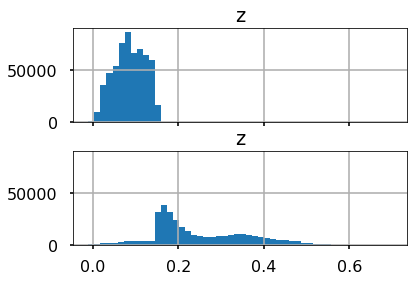

In [13]:
fig, axes = plt.subplots(2, sharex=True, sharey=True)
dr7_and_nsa.hist('z', bins=50, ax=axes[0])
a = dr7_no_nsa.hist('z', bins=50, ax=axes[1])

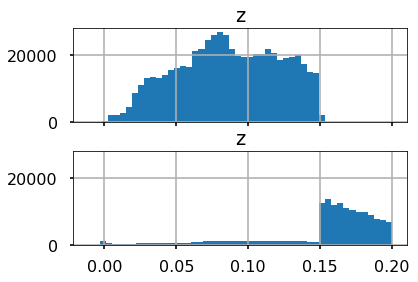

In [14]:
fig, axes = plt.subplots(2, sharex=True, sharey=True)
dr7_and_nsa[dr7_and_nsa['z'] < 0.2].hist('z', bins=50, ax=axes[0])
a = dr7_no_nsa[dr7_no_nsa['z'] < 0.2].hist('z', bins=50, ax=axes[1])

The mismatch is almost completely due to redshift - NSA only goes to z = 0.15, but DR7 goes to z = 0.6. That's okay - we're only looking for fairly nearby galaxies with detectable bars

### Check how Heckman and DR7 match (perfectly)

In [15]:
heckman_and_dr7, heckman_no_dr7 = match_galaxies_to_catalog_pandas(heckman, dr7)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_and_dr7), len(heckman_no_dr7)))

Galaxies matched: 18286. Galaxies missed: 0.


Perfect - all Heckman radio sources are in DR7 , as expected - Heckman used DR7 to crossmatch for sources

### Check how Galloway and DR7 match

In [16]:
galloway_and_dr7, galloway_no_dr7 = match_galaxies_to_catalog_pandas(galloway, dr7)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(galloway_and_dr7), len(galloway_no_dr7)))

Galaxies matched: 19756. Galaxies missed: 0.


Perfect - all Galloway sources in DR7, as expected

### Check how Galloway and NSA match

In [17]:
galloway_and_nsa, galloway_no_nsa = match_galaxies_to_catalog_pandas(galloway, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(galloway_and_nsa), len(galloway_no_nsa)))

Galaxies matched: 19261. Galaxies missed: 495.


Almost perfectly- a few percent dropped. I should check why it's not perfect, but for now, let's continue.

### Check how NSA and Galaxy Zoo match (90%)

In [18]:
nsa_and_gz, nsa_no_gz = match_galaxies_to_catalog_pandas(galaxy_zoo, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(nsa_and_gz), len(nsa_no_gz)))

Galaxies matched: 218759. Galaxies missed: 20936.


Yep, 90% match. 10% loss is most likely from radius cut.

### Check how DR7-NSA-GZ subset match to Heckman (badly - 25%!)

In [19]:
heckman_gz, heckman_only = match_galaxies_to_catalog_pandas(heckman, nsa_and_gz)
print('LERG remaining: {} of {}'.format(heckman_gz['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_gz), len(heckman_only['lerg'])))

LERG remaining: 2565 of 9863
Galaxies matched: 5051. Galaxies missed: 13235.


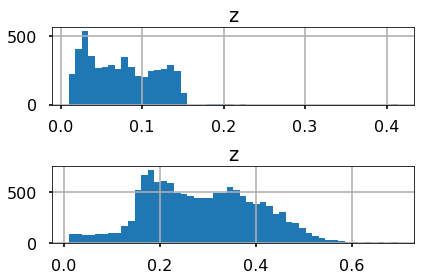

In [20]:
fig, axes = plt.subplots(2)
heckman_gz.hist('z', bins=50, ax=axes[0])
heckman_only.hist('z', bins=50, ax=axes[1])
fig.tight_layout()

The big drop here is because of the DR7-NSA mismatch in z. Most, but not all, of the missed galaxies are at z > 0.15. This is because the NSA catalog is limited to 0.15 but DR7 is not - see above

In [21]:
heckman_gz, heckman_only = match_galaxies_to_catalog_pandas(heckman[heckman['z'] < 0.15], nsa_and_gz)
print('LERG remaining: {} of {}'.format(heckman_gz['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_gz), len(heckman_only['lerg'])))

/Data/repos/find_agn/shared_utilities.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  galaxies['best_match'] = best_match_catalog_index
/Data/repos/find_agn/shared_utilities.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  galaxies['sky_separation'] = sky_separation.to(u.arcsec).value


LERG remaining: 2558 of 9863
Galaxies matched: 5040. Galaxies missed: 1145.


After accounting for z, the match is 85% complete. The remainder is most likely additional GZ cuts on spatial extent, magnitude etc.

### Let's do it - link Heckman to DR7, GZ to NSA, then link both

In [22]:
heckman_dr7, heckman_only = match_galaxies_to_catalog_pandas(heckman, dr7)
print('LERG remaining: {} of {}'.format(heckman_dr7['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_dr7), len(heckman)))

LERG remaining: 9863 of 9863
Galaxies matched: 18286. Galaxies missed: 18286.


In [23]:
gz_nsa, gz_only = match_galaxies_to_catalog_pandas(galaxy_zoo, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(gz_nsa), len(gz_only)))

Galaxies matched: 218759. Galaxies missed: 20936.


In [24]:
gz_heckman, heckman_no_gz = match_galaxies_to_catalog_pandas(heckman_dr7, gz_nsa)
print('LERG remaining: {} of {}'.format(gz_heckman['lerg'].sum(), heckman_dr7['lerg'].sum()))
print('Galaxies remaining: {} of {}'.format(len(gz_heckman), len(heckman_no_gz)))

LERG remaining: 2565 of 9863
Galaxies remaining: 5051 of 13235


And let's also link Galloway to DR7 and NSA for a BPT-selected comparison catalog

In [25]:
galloway_dr7, galloway_only = match_galaxies_to_catalog_pandas(galloway, dr7)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(galloway_dr7), len(galloway_only)))

Galaxies matched: 19756. Galaxies missed: 0.


In [26]:
galloway_dr7_nsa, galloway_only = match_galaxies_to_catalog_pandas(galloway_dr7, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(galloway_dr7_nsa), len(galloway_only)))
print(galloway_dr7_nsa['bpt_class'].value_counts())

Galaxies matched: 19261. Galaxies missed: 495.
star-forming    10975
undetermined     3518
composite        2796
liner            1300
agn               672
Name: bpt_class, dtype: int64


### Todo: What's the original distributions in mass, colour, z for each catalog?

## Do Science

Make a new 'agn_type' column so Heckman's data is easier to work with

In [27]:
def get_agn_type(series):
    if series['herg'] == 1:
        return 'herg'
    elif series['lerg'] == 1:
        return 'lerg'
    else:
        return 'star-forming'

In [28]:
galaxies = gz_heckman.copy()
galaxies['p_bar'] = galaxies['t03_bar_a06_bar_debiased']  # use debiased value or no?
galaxies = galaxies.dropna(subset=['p_bar', 'petro_ba90'])
galaxies['agn_type'] = galaxies.apply(get_agn_type, axis=1)

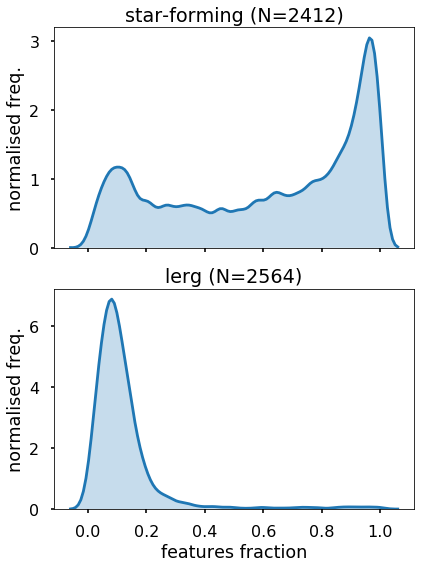

In [29]:
agn_types = ['lerg', 'star-forming']
lerg = galaxies[galaxies['agn_type'] == 'lerg']
sf = galaxies[galaxies['agn_type'] == 'star-forming']
fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax = sns.kdeplot(data=sf['t01_smooth_or_features_a02_features_or_disk_fraction'], ax=axes[0], shade=True, bw=0.02)
ax.legend_.remove()
ax.set_title('star-forming (N={})'.format(len(sf)))
ax.set_ylabel('normalised freq.')
ax = sns.kdeplot(data=lerg['t01_smooth_or_features_a02_features_or_disk_fraction'], ax=axes[1], shade=True, bw=0.02)
ax.set_title('lerg (N={})'.format(len(lerg)))
ax.set_xlabel('features fraction')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

Galaxies with LERGs, generally, are WAY less featured than star-forming galaxies. I think this might be a selection effect. Most galaxies are smooth, and so most AGN are smooth. But star-forming galaxies are generally featured. We can't select smooth non-AGN galaxies because we require radio sources. This would be more informative checked against the full GZ population.

** This whole analysis is really only looking at the featured tail (N < 100) of the LERG population (N = 2500) **

I should plot a bunch of small random thumbnails of each to get a sense for what the different populations look like

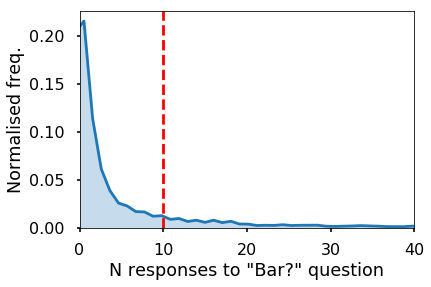

In [30]:
galaxies['bar_answers'] = galaxies['t03_bar_a06_bar_count'] + galaxies['t03_bar_a06_bar_count']
ax = sns.kdeplot(data=galaxies['bar_answers'], shade=True, legend=False)
ax.set_xlabel('N responses to "Bar?" question')
ax.set_ylabel('Normalised freq.')
_ = ax.set_xlim([0, 40])
ax.axvline(10, color='r', linestyle='--')

Text(0,0.5,'Normalised freq.')

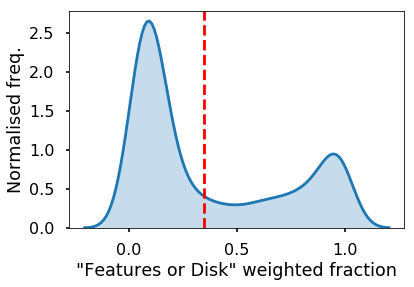

In [31]:
ax = sns.kdeplot(data=galaxies['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'], shade=True, legend=False)
ax.axvline(0.35, color='r', linestyle='--')
ax.set_xlabel('"Features or Disk" weighted fraction')
ax.set_ylabel('Normalised freq.')

** When we filter for galaxies with p_bar as defined by Mel is we lose 85% of the LERG population - because they're rarely featured **

In [32]:
def filter_for_pbar(df):
    # apply filters - keep only well-measured galaxies
    print('initial count: ', len(df))
    # > 10 answer 'is there a sign of a bar?
    df = df[df['t03_bar_a06_bar_count'] + df['t03_bar_a06_bar_count'] > 10]
    print('with 10 bar answers: ', len(df))
    # p(features or disk) > 0.35?
    # not clear if these should be debiased
    df = df[df['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'] > 0.35] 
    print('with features fraction > 0.35:', len(df))
    # p(not edge on) > 0.6?
    # not clear if these should be debiased
    df = df[df['t02_edgeon_a05_no_weighted_fraction'] > 0.6] 
    print('with edge-on fraction > 0.6:', len(df))
    return df

In [33]:
galaxies = filter_for_pbar(galaxies)

initial count:  5050
with 10 bar answers:  810
with features fraction > 0.35: 796
with edge-on fraction > 0.6: 764


Only 15% have valid pbar measurements, as defined by Mel. This is mostly because quite few galaxies have > 10 answers to 'is there a bar?'. That's because about 2/3rds of people answer 'smooth' to 'featured or smooth?'. But why should we exclude 'smooth'? Isn't 'smooth' an indicator of the absence of a bar? Also remember that all galaxies are star-forming.

What do we know about AGN in galaxies which are smooth v featured?

### Investigate how agn type correlates with bar fraction

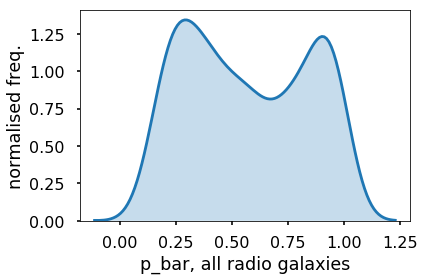

In [34]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data=galaxies['p_bar'], ax=ax, shade=True)
ax.set_xlabel('p_bar, all radio galaxies')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

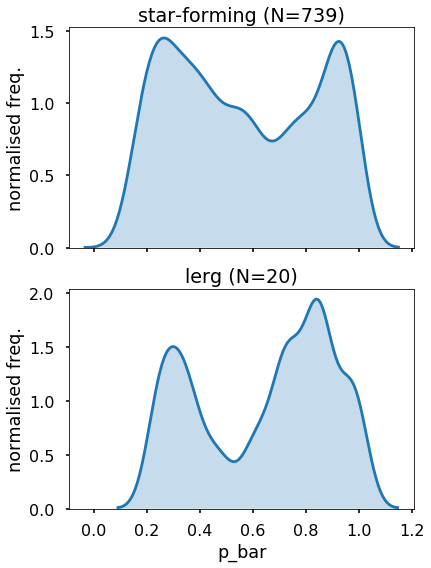

In [35]:
agn_types = ['lerg', 'star-forming']
lerg = galaxies[galaxies['agn_type'] == 'lerg']
sf = galaxies[galaxies['agn_type'] == 'star-forming']
fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax = sns.kdeplot(data=sf['p_bar'], ax=axes[0], shade=True, bw=0.05)
ax.legend_.remove()
ax.set_title('star-forming (N={})'.format(len(sf)))
ax.set_ylabel('normalised freq.')
ax = sns.kdeplot(data=lerg['p_bar'], ax=axes[1], shade=True, bw=0.05)
ax.set_title('lerg (N={})'.format(len(lerg)))
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

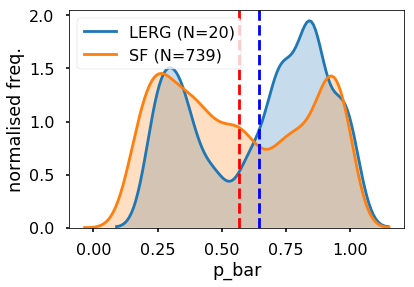

In [36]:
ax = sns.kdeplot(data=lerg['p_bar'], shade=True, bw=0.05, legend=False)
ax = sns.kdeplot(data=sf['p_bar'], shade=True, bw=0.05, legend=False)
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend([
    'LERG (N={})'.format(len(lerg)), 
    'SF (N={})'.format(len(sf))
])
ax.axvline(lerg['p_bar'].mean(), color='b', linestyle='--')
ax.axvline(sf['p_bar'].mean(), color='r', linestyle='--')

Both show a bimodal distribution in pbar, as with galaxies in general. LERGs have a particular clear distribution, and are slightly more likely to be barred than SF-radio galaxies.

### Repeat the pbar analysis for Mel's catalog

In [37]:
opt_galaxies = galloway_dr7_nsa.copy()
opt_agn_types = set(opt_galaxies['bpt_class'].unique()) - {'undetermined'}

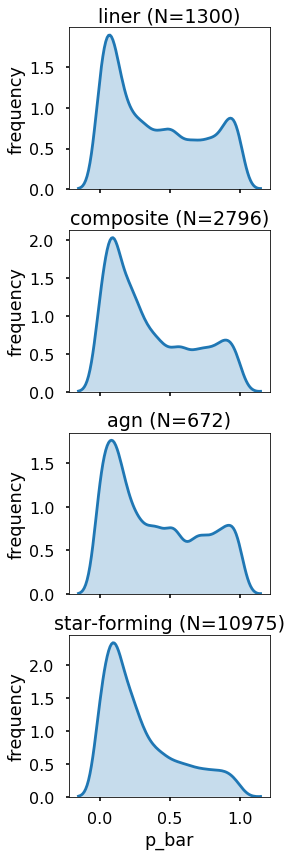

In [38]:
fig, axes = plt.subplots(len(opt_agn_types), figsize=(4, 12), sharex=True)
for agn_type_index, agn_type in enumerate(opt_agn_types):
    selected = opt_galaxies[opt_galaxies['bpt_class'] == agn_type]
    ax = sns.kdeplot(data=selected['p_bar'], ax=axes[agn_type_index], shade=True, bw=0.05, legend=False)
    ax.set_title('{} (N={})'.format(agn_type, len(selected)))
    ax.set_ylabel('frequency')
ax.set_xlabel('p_bar')
fig.tight_layout()

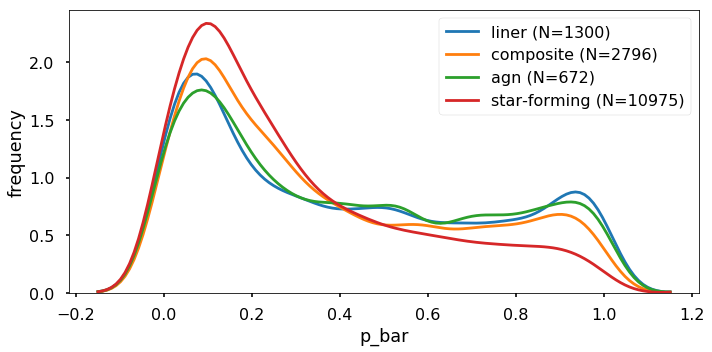

In [39]:
legend = []
fig, ax = plt.subplots(figsize=(10, 5))
for agn_type_index, agn_type in enumerate(opt_agn_types):
    selected = opt_galaxies[opt_galaxies['bpt_class'] == agn_type]
    ax = sns.kdeplot(data=selected['p_bar'], shade=False, bw=0.05, legend=False)
    legend.append('{} (N={})'.format(agn_type, len(selected)))
    ax.set_ylabel('frequency')
ax.set_xlabel('p_bar')
ax.legend(legend)
fig.tight_layout()

### Control for mass and colour

What's the general distribution of mass and colour?

In [40]:
def define_galaxy_bulk_properties(df):
    df = df.copy()
    df['g-r'] = df['elpetro_mag_g'] - df['elpetro_mag_r']
    df['u-r'] = df['elpetro_mag_u'] - df['elpetro_mag_r']
    df['mass'] = df['elpetro_mass']
    df = df[df['mass'] > 1] # avoid div0 errors
    df['log_mass'] = np.log10(df['elpetro_mass'])
    return df

In [41]:
galaxies = define_galaxy_bulk_properties(galaxies)

I thought that galaxies were supposed to be bimodel in colour. That's not really true with the u-r fluxes of my sample. Maybe I should follow the literature and use mag colours.

In [42]:
def plot_color_mag_diagram(df, ax=None):
    ax = sns.kdeplot(data=df['log_mass'], data2=df['g-r'], bw=0.02, ax=ax)
    ax.set_ylabel('g-r')
    ax.set_xlabel('log mass')
    plt.gcf().tight_layout()
    return ax

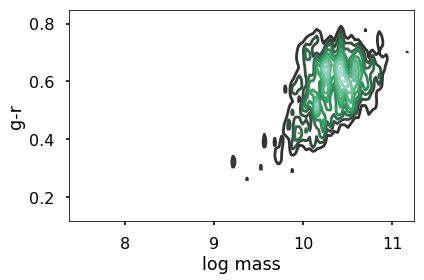

In [43]:
plot_color_mag_diagram(galaxies)

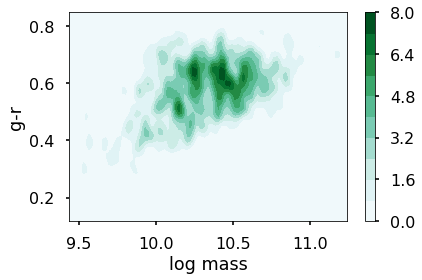

In [44]:
selected_galaxies = galaxies[(galaxies['log_mass'] > 9.5) &  (galaxies['g-r'] < 1.0) & (galaxies['g-r'] > 0.)]
ax = sns.kdeplot(data=selected_galaxies['log_mass'], data2=selected_galaxies['g-r'], shade=True, cbar=True, bw=0.02)
ax.set_ylabel('g-r')
ax.set_xlabel('log mass')
plt.gcf().tight_layout()

### How are the mass and colour distributions different for LERG and SF?

In [45]:
def compare_bulk_properties(sample_a, sample_b, show_points, bw_mass, bw_colour, bw_redshift, names):
    fig, axes = plt.subplots(3, 1, figsize=(8, 9))

    ax = sns.kdeplot(data=sample_a['log_mass'], shade=True, bw=bw_mass[0], ax=axes[0], legend=False)
    ax = sns.kdeplot(data=sample_b['log_mass'], shade=True, bw=bw_mass[1], ax=axes[0], legend=False)
    if show_points:
        for val in sample_b['log_mass']:
            ax.axvline(val, color='orange', linestyle='--', linewidth=1.0)
    ax.set_title('mass')
    ax.legend(names)

    ax = sns.kdeplot(data=sample_a['g-r'], shade=True, bw=bw_colour[0], ax=axes[1], legend=False)
    ax = sns.kdeplot(data=sample_b['g-r'], shade=True, bw=bw_colour[1], ax=axes[1], legend=False)
    if show_points:
        for val in sample_b['g-r']:
            ax.axvline(val, color='orange', linestyle='--', linewidth=1.0)
    ax.legend(names)
    ax.set_title('colour')

    ax = sns.kdeplot(data=sample_a['z'], shade=True, bw=bw_redshift[0], ax=axes[2], legend=False)
    ax = sns.kdeplot(data=sample_b['z'], shade=True, bw=bw_redshift[1], ax=axes[2], legend=False)
    if show_points:
        for val in sample_b['z']:
            ax.axvline(val, color='orange', linestyle='--', linewidth=1.0)
    ax.legend(names)
    ax.set_title('redshift')
    fig.tight_layout()

In [46]:
sf = galaxies[galaxies['agn_type'] == 'star-forming']
lerg = galaxies[galaxies['agn_type'] == 'lerg']

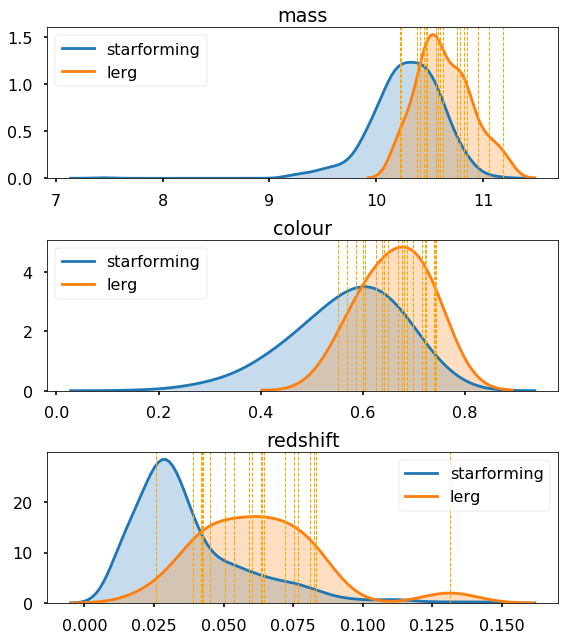

In [47]:
compare_bulk_properties(sf, lerg, True, (0.1, 0.1), (0.05, 0.05), (0.005, 0.01), ['starforming', 'lerg'])

### Compare bar-ness for a mass-matched sample

In [48]:
def match_distributions_between_catalogs(catalog_to_match, catalog_to_sample, value_col, limits, bw_tuple):
    catalog_to_match_kde = gaussian_kde(catalog_to_match[value_col], bw_method=bw_tuple[0])  # 0.15
    fig, ax = plt.subplots(1, figsize=(8, 3))
    sample_points = np.arange(limits[0], limits[1], 0.001)
    
    ax.plot(sample_points, catalog_to_match_kde.evaluate(sample_points))  # check it's working
    ax.set_xlim([limits[0], limits[1]])

    catalog_to_sample_kde = gaussian_kde(catalog_to_sample[value_col], bw_method=bw_tuple[1])  # it's important to fit the apparent distribution - normalise
    ax.plot(sample_points, catalog_to_sample_kde.evaluate(sample_points))  # check it's working
    
    ax.legend(['catalog to match', 'catalog to sample'])
    
    catalog_to_sample['resample_p'] = catalog_to_match_kde.evaluate(catalog_to_sample[value_col]) / catalog_to_sample_kde.evaluate(catalog_to_sample[value_col])
    catalog_to_sample['resample_p'] = catalog_to_sample['resample_p'] / catalog_to_sample['resample_p'].mean()
    catalog_sampled = catalog_to_sample.sample(len(catalog_to_match)*100, replace=True, weights=catalog_to_sample['resample_p'])
    
    return catalog_sampled

/data/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/data/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


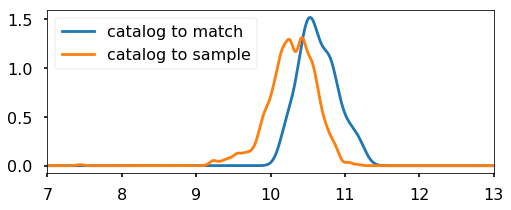

In [49]:
sf_mass_matched = match_distributions_between_catalogs(lerg, sf, 'log_mass', (7, 13), (0.4, 0.15))

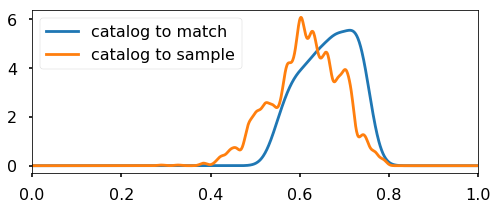

In [50]:
sf_mass_color_matched = match_distributions_between_catalogs(lerg, sf_mass_matched, 'g-r', (0, 1), (0.4, 0.1))

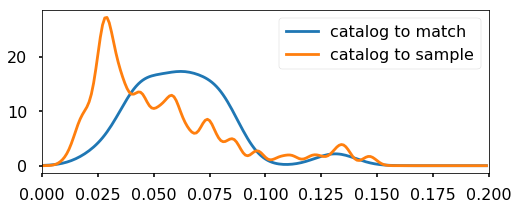

In [51]:
sf_matched = match_distributions_between_catalogs(lerg, sf_mass_color_matched, 'z', (0, 0.2), (0.4, 0.1))

In [52]:
def visualise_match_quality(catalog_to_match, catalog_to_sample, sample, names, bw_mass, bw_colour, bw_redshift):
    fig, axes = plt.subplots(3, 1, figsize=(8, 9))
    lerg_mass_ax = sns.kdeplot(data=catalog_to_match['log_mass'], shade=True, bw=bw_mass, ax=axes[0], legend=False)
    ax = sns.kdeplot(data=catalog_to_sample['log_mass'], shade=True, bw=bw_mass, ax=axes[0], legend=False)
    ax = sns.kdeplot(data=sample['log_mass'], shade=True, bw=0.15, ax=axes[0], legend=False)
    lerg_mass_ax.set_title('mass')
    lerg_mass_ax.legend(names)

    ax = sns.kdeplot(data=catalog_to_match['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
    ax = sns.kdeplot(data=catalog_to_sample['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
    ax = sns.kdeplot(data=sample['g-r'], shade=True, bw=bw_colour, ax=axes[1], legend=False)
    ax.legend(names)
    ax.set_title('colour')

    ax = sns.kdeplot(data=catalog_to_match['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax = sns.kdeplot(data=catalog_to_sample['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax = sns.kdeplot(data=sample['z'], shade=True, bw=bw_redshift, ax=axes[2], legend=False)
    ax.legend(names)
    ax.set_title('redshift')
    
    fig.tight_layout()

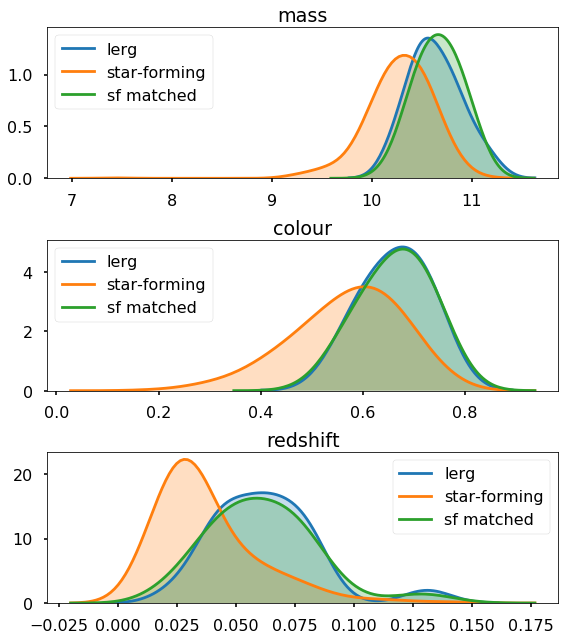

In [53]:
visualise_match_quality(lerg, sf, sf_matched, ['lerg', 'star-forming', 'sf matched'], 0.15, 0.05, 0.01)

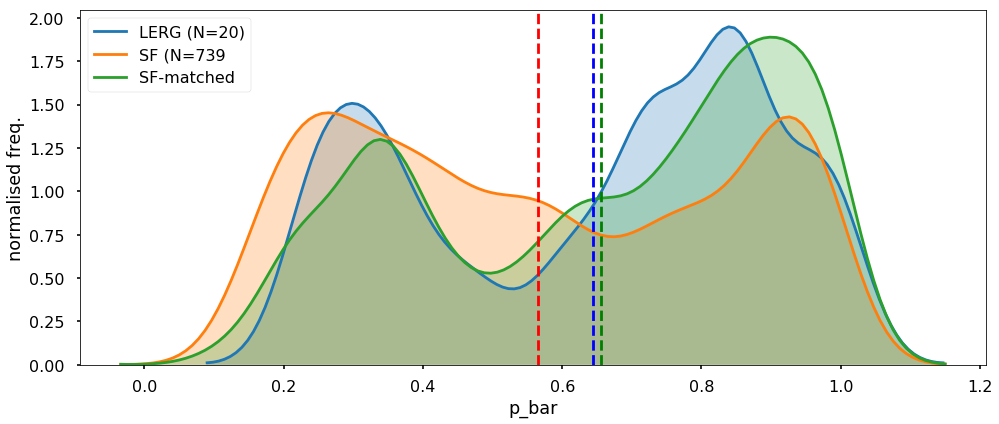

In [54]:
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.kdeplot(data=lerg['p_bar'], shade=True, bw=0.05, legend=False)
ax = sns.kdeplot(data=sf['p_bar'], shade=True, bw=0.05, legend=False)
ax = sns.kdeplot(data=sf_matched['p_bar'], shade=True, bw=0.05, legend=False)
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend([
    'LERG (N={})'.format(len(lerg)), 
    'SF (N={}'.format(len(sf)),
    'SF-matched '.format(len(sf_matched))
])
ax.axvline(lerg['p_bar'].mean(), color='b', linestyle='--')
ax.axvline(sf['p_bar'].mean(), color='r', linestyle='--')
ax.axvline(sf_matched['p_bar'].mean(), color='g', linestyle='--')
fig.tight_layout()

### TODO: Statistically speaking, how similar are these distributions?

In [93]:
def kde_to_cdf(kde, test_range, visualise=False):
    kde_sums = np.ones_like(test_range)
    for sample_n, sample in enumerate(test_range):
        kde_sums[sample_n] = kde.integrate_box_1d(low=test_range.min(), high=sample)
        cdf = interp1d(test_range, kde_sums)
    if visualise:
        plt.plot(test_range, kde_sums)
    return cdf

In [134]:
def kuiper_test(sample, possible_parent, parent_bw=None, visualise=False, show_score=False):
    # see http://docs.astropy.org/en/stable/api/astropy.stats.kuiper.html#astropy.stats.kuiper
    # see http://www.aip.de/groups/soe/local/numres/bookcpdf/c14-3.pdf
    
    parent_kde = gaussian_kde(possible_parent, bw_method=parent_bw)
    test_range = np.linspace(0.0, 1.0, 5000)
    parent_cdf = kde_to_cdf(parent_kde, test_range)
    raw_score, p_of_score = stats.kuiper(data=sample, cdf=parent_cdf)
    
    if visualise:
        fig, (ax1, ax2) = plt.subplots(nrows=2)
        ax1.plot(test_range, parent_kde(test_range))
        ax2.plot(test_range, parent_cdf(test_range))
    if show_score:
        print('Kuiper Score: {:.3}. Prob. of that score or worse: {:.3}'.format(raw_score, p_of_score))
    return raw_score, p_of_score

Kuiper Score: 0.205. Prob. of that score or worse: 0.897


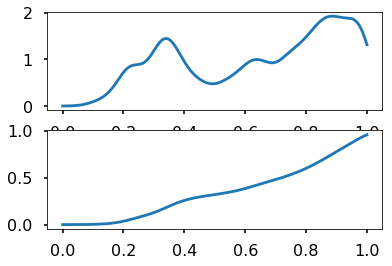

In [112]:
raw_value, p_value = kuiper_test(sample=lerg['p_bar'], possible_parent=sf_matched['p_bar'], parent_bw=0.15, show=True)

In [157]:
# lerg_scores = []
# for n in range(100):
#    score, _ = kuiper_test(sample=lerg['p_bar'], possible_parent=sf_matched.sample(len(sf))['p_bar'], parent_bw=0.15, show_score=False, visualise=False)
#    lerg_scores.append(score)
expected_sf_scores = []
for n in range(100):
    score, _ = kuiper_test(sample=sf_matched.sample(len(lerg))['p_bar'], possible_parent=sf_matched.sample(len(sf))['p_bar'], parent_bw=0.15, show_score=False, visualise=False)
    expected_sf_scores.append(score)

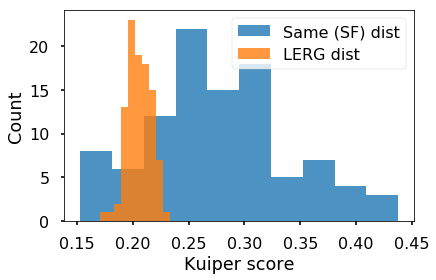

In [159]:
_ = plt.hist(expected_sf_scores, alpha=0.8)
_ = plt.hist(lerg_scores, alpha=0.8)
plt.legend(['Same (SF) dist', 'LERG dist'])
plt.xlabel('Kuiper score')
plt.ylabel('Count')
plt.tight_layout()

In [228]:
# ks_sf_scores = []
for n in range(10000):
    score, _ = ks_2samp(sf_matched.sample(len(lerg))['p_bar'], sf_matched.sample(len(lerg))['p_bar'])
    ks_sf_scores.append(score)
# ks_lerg_scores = []
for n in range(10000):
    score, _ = ks_2samp(lerg['p_bar'], sf_matched.sample(len(lerg))['p_bar'])
    ks_lerg_scores.append(score)

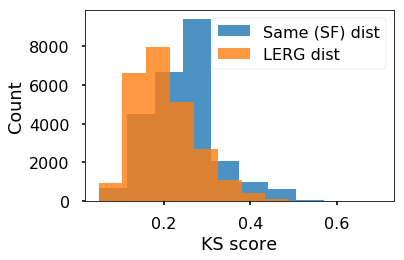

In [229]:
_ = plt.hist(ks_sf_scores, alpha=0.8)
_ = plt.hist(ks_lerg_scores, alpha=0.8)
plt.legend(['Same (SF) dist', 'LERG dist'])
plt.xlabel('KS score')
plt.ylabel('Count')
plt.tight_layout()

### Repeat the same approach for the BPT sample

In [113]:
opt_galaxies = define_galaxy_bulk_properties(opt_galaxies)

In [114]:
sf_opt = opt_galaxies[opt_galaxies['bpt_class'] == 'star-forming']
agn_opt = opt_galaxies[opt_galaxies['bpt_class'] == 'agn']
liner_opt = opt_galaxies[opt_galaxies['bpt_class'] == 'liner']

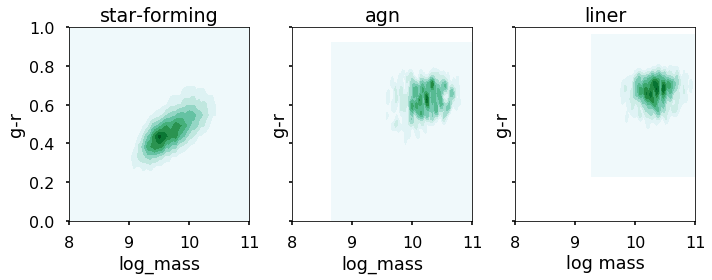

In [115]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharex=True, sharey=True)
ax = sns.kdeplot(data=sf_opt['log_mass'], data2=sf_opt['g-r'], bw=0.02, ax=axes[0], shade=True)
ax.set_title('star-forming')
ax = sns.kdeplot(data=agn_opt['log_mass'], data2=agn_opt['g-r'], bw=0.02, ax=axes[1], shade=True)
ax.set_title('agn')
ax = sns.kdeplot(data=liner_opt['log_mass'], data2=liner_opt['g-r'], bw=0.02, ax=axes[2], shade=True)
ax.set_title('liner')
ax.set_ylabel('g-r')
ax.set_xlabel('log mass')
ax.set_ylim([0, 1])
ax.set_xlim([8, 11])
fig.tight_layout()

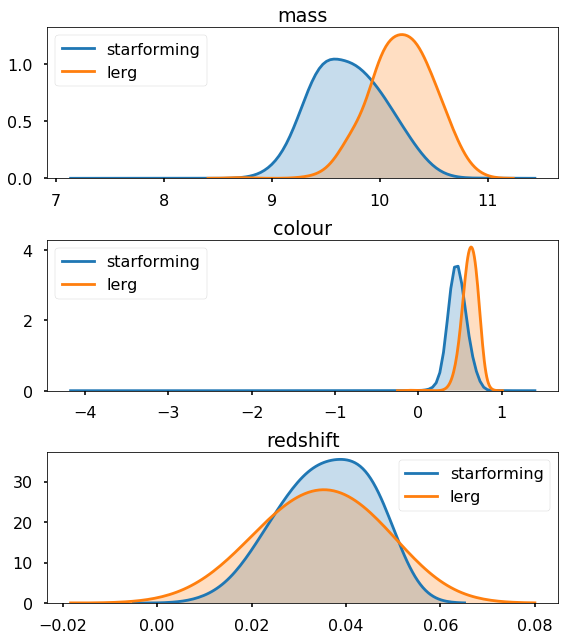

In [116]:
compare_bulk_properties(sf_opt, agn_opt, False, (0.1, 0.1), (0.05, 0.05), (0.005, 0.01), ['starforming', 'lerg'])

/data/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/data/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


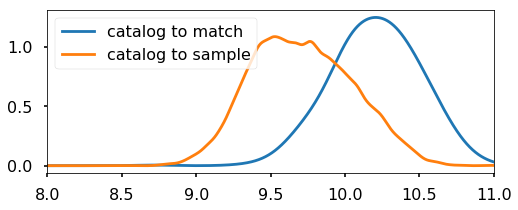

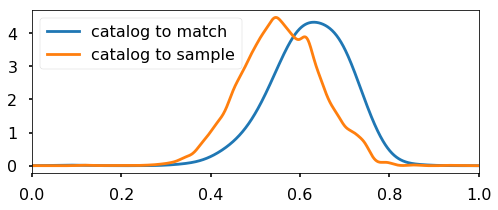

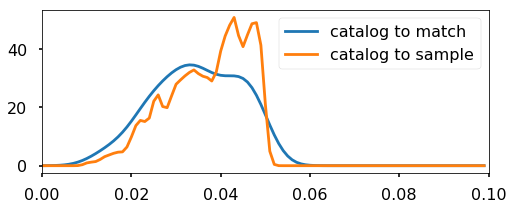

In [117]:
sf_mass_matched = match_distributions_between_catalogs(agn_opt, sf_opt, 'log_mass', (8, 11), (0.4, 0.1))
sf_mass_color_matched = match_distributions_between_catalogs(agn_opt, sf_mass_matched, 'g-r', (0, 1), (0.4, 0.1))
sf_opt_matched = match_distributions_between_catalogs(agn_opt, sf_mass_color_matched, 'z', (0, 0.1), (0.4, 0.1))

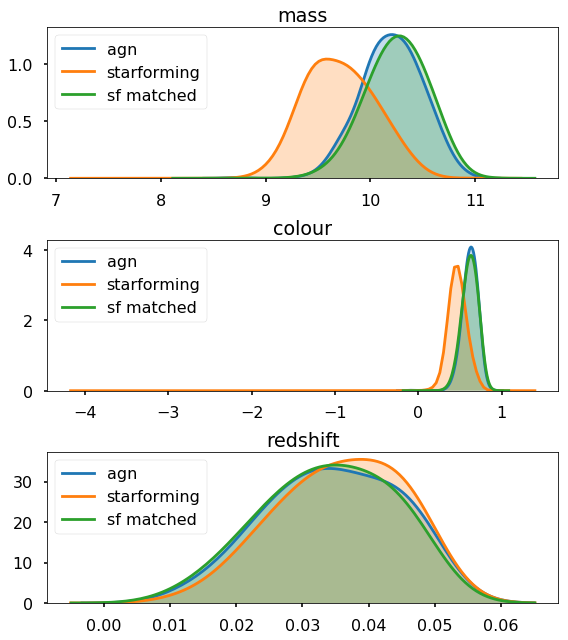

In [118]:
visualise_match_quality(agn_opt, sf_opt, sf_opt_matched, ['agn', 'starforming', 'sf matched'], 0.1, 0.05, 0.005)

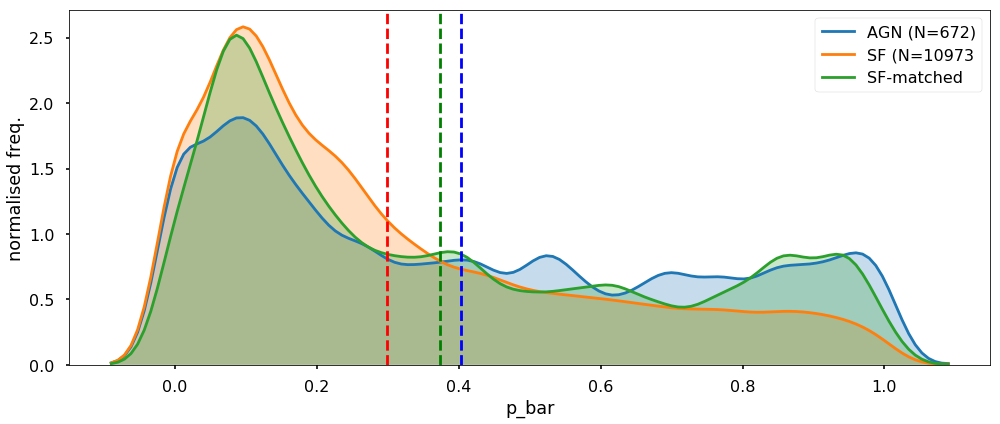

In [119]:
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.kdeplot(data=agn_opt['p_bar'], shade=True, bw=0.03, legend=False)
ax = sns.kdeplot(data=sf_opt['p_bar'], shade=True, bw=0.03, legend=False)
ax = sns.kdeplot(data=sf_opt_matched['p_bar'], shade=True, bw=0.03, legend=False)
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend([
    'AGN (N={})'.format(len(agn_opt)), 
    'SF (N={}'.format(len(sf_opt)),
    'SF-matched '.format(len(sf_opt_matched))
])
ax.axvline(agn_opt['p_bar'].mean(), color='b', linestyle='--')
ax.axvline(sf_opt['p_bar'].mean(), color='r', linestyle='--')
ax.axvline(sf_opt_matched['p_bar'].mean(), color='g', linestyle='--')
fig.tight_layout()

Kuiper Score: 0.106. Prob. of that score or worse: 1.83e-05


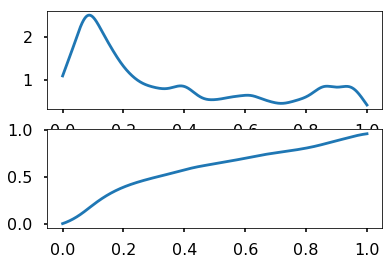

In [132]:
raw_value, p_value = kuiper_test(sample=agn_opt['p_bar'], possible_parent=sf_opt_matched['p_bar'].sample(len(sf_opt)), parent_bw=0.1, show=True)

In [146]:
# agn_scores = []
for n in range(20):
    score, _ = kuiper_test(sample=agn_opt['p_bar'], possible_parent=sf_opt_matched.sample(len(sf_opt))['p_bar'], parent_bw=0.1, show_score=True, visualise=False)
    agn_scores.append(score)

Kuiper Score: 0.109. Prob. of that score or worse: 7.34e-06
Kuiper Score: 0.108. Prob. of that score or worse: 1.04e-05
Kuiper Score: 0.121. Prob. of that score or worse: 2.05e-07
Kuiper Score: 0.113. Prob. of that score or worse: 2.45e-06
Kuiper Score: 0.112. Prob. of that score or worse: 3.17e-06
Kuiper Score: 0.107. Prob. of that score or worse: 1.2e-05
Kuiper Score: 0.111. Prob. of that score or worse: 4.2e-06
Kuiper Score: 0.113. Prob. of that score or worse: 2.23e-06
Kuiper Score: 0.105. Prob. of that score or worse: 2.03e-05
Kuiper Score: 0.11. Prob. of that score or worse: 5.88e-06
Kuiper Score: 0.115. Prob. of that score or worse: 1.38e-06
Kuiper Score: 0.113. Prob. of that score or worse: 2.07e-06
Kuiper Score: 0.106. Prob. of that score or worse: 1.8e-05
Kuiper Score: 0.106. Prob. of that score or worse: 1.77e-05
Kuiper Score: 0.109. Prob. of that score or worse: 6.35e-06
Kuiper Score: 0.0984. Prob. of that score or worse: 0.000112
Kuiper Score: 0.11. Prob. of that score or 

In [147]:
# expected_scores = []
for n in range(20):
    score, _ = kuiper_test(sample=sf_opt_matched.sample(672)['p_bar'], possible_parent=sf_opt_matched.sample(len(sf_opt))['p_bar'], parent_bw=0.1, show_score=True, visualise=False)
    expected_scores.append(score)

Kuiper Score: 0.0603. Prob. of that score or worse: 0.132
Kuiper Score: 0.0482. Prob. of that score or worse: 0.461
Kuiper Score: 0.0697. Prob. of that score or worse: 0.0351
Kuiper Score: 0.0787. Prob. of that score or worse: 0.0075
Kuiper Score: 0.0869. Prob. of that score or worse: 0.00151
Kuiper Score: 0.083. Prob. of that score or worse: 0.00333
Kuiper Score: 0.0803. Prob. of that score or worse: 0.00556
Kuiper Score: 0.0644. Prob. of that score or worse: 0.0768
Kuiper Score: 0.0565. Prob. of that score or worse: 0.206
Kuiper Score: 0.0738. Prob. of that score or worse: 0.0179
Kuiper Score: 0.064. Prob. of that score or worse: 0.0813
Kuiper Score: 0.0806. Prob. of that score or worse: 0.00529
Kuiper Score: 0.071. Prob. of that score or worse: 0.0285
Kuiper Score: 0.0652. Prob. of that score or worse: 0.0691
Kuiper Score: 0.0744. Prob. of that score or worse: 0.0162
Kuiper Score: 0.0651. Prob. of that score or worse: 0.0692
Kuiper Score: 0.0577. Prob. of that score or worse: 0.181


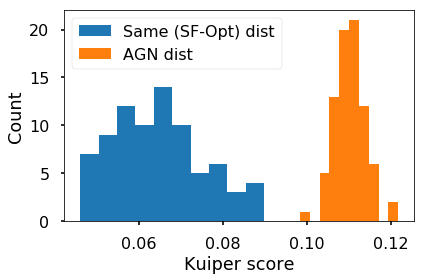

In [152]:
_ = plt.hist(expected_scores)
_ = plt.hist(agn_scores)
plt.legend(['Same (SF-Opt) dist', 'AGN dist'])
plt.xlabel('Kuiper score')
plt.ylabel('Count')
plt.tight_layout()

In [177]:
ks_sf_opt_scores = []
for n in range(50000):
    score, _ = ks_2samp(sf_opt_matched.sample(len(agn_opt))['p_bar'], sf_opt_matched.sample(len(agn_opt))['p_bar'])
    ks_sf_opt_scores.append(score)
ks_agn_opt_scores = []
for n in range(50000):
    score, _ = ks_2samp(agn_opt['p_bar'], sf_opt_matched.sample(len(agn_opt))['p_bar'])
    ks_agn_opt_scores.append(score)

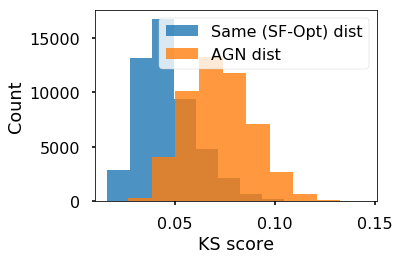

In [178]:
_ = plt.hist(ks_sf_opt_scores, alpha=0.8)
_ = plt.hist(ks_agn_opt_scores, alpha=0.8)
plt.legend(['Same (SF-Opt) dist', 'AGN dist'])
plt.xlabel('KS score')
plt.ylabel('Count')
plt.tight_layout()

In [234]:
def find_score_overlap(scores_a, scores_b, test_range, visualise=False, a_bw=None, b_bw=None):

    scores_a_kde = gaussian_kde(scores_a, a_bw)
    scores_b_kde = gaussian_kde(scores_b, b_bw)

    scores_a_est = scores_a_kde(test_range)
    scores_b_est = scores_b_kde(test_range)

    min_score_est = np.fmin(scores_a_est, scores_b_est)
    min_score_interp = interp1d(test_range, min_score_est)

    min_score_cdf = np.zeros_like(test_range)
    for sample_n, sample in enumerate(test_range):
        sum, _ = integrate.quad(min_score_interp, 0, sample)
        min_score_cdf[sample_n] = sum
    
    if visualise:
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
        ax1.plot(test_range, scores_a_est)
        ax1.plot(test_range, scores_b_est)
        ax1.plot(test_range, min_score_est)
        ax2.plot(test_range, min_score_interp(test_range))
        ax3.plot(test_range, min_score_cdf)
        
    return min_score_cdf[-1]

/data/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/data/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Estimated prob. of consistent distributions: 0.401


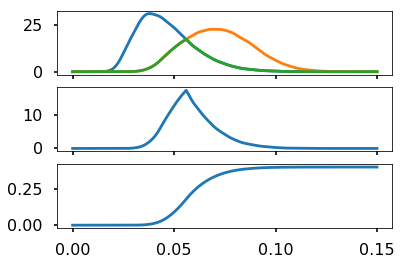

In [213]:
test_range = np.linspace(0., 0.15, 5000)
score_overlap = find_score_overlap(ks_sf_opt_scores, ks_agn_opt_scores, test_range, visualise=True)
print('Estimated prob. of consistent distributions: {:.3}'.format(score_overlap))

/data/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/data/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Estimated prob. of consistent distributions: 0.857


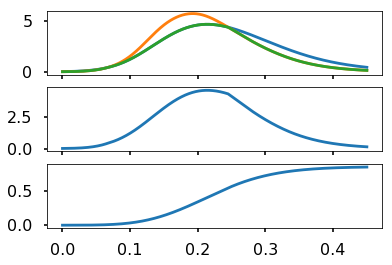

In [235]:
test_range = np.linspace(0., 0.45, 5000)
score_overlap = find_score_overlap(ks_sf_scores, ks_lerg_scores, test_range, visualise=True, a_bw=0.5, b_bw=0.5)
print('Estimated prob. of consistent distributions: {:.3}'.format(score_overlap))